# Supplementary Information: Holmes *et al.* 2017

# 3. An unpooled model

In [1]:
%pylab inline

import numpy as np
import pandas as pd
import pystan
import scipy
import seaborn as sns

import tools

import warnings
warnings.filterwarnings('ignore')

sns.set_context('notebook')

Populating the interactive namespace from numpy and matplotlib


/Users/lpritc/Development/GitHub/Supplementary_Info/SI_Holmes_etal_2016/venv-SI_Holmes_2016/lib/python3.5/site-packages/Cython/Distutils/old_build_ext.py:30: UserWarning: Cython.Distutils.old_build_ext does not properly handle dependencies and is deprecated.
  "Cython.Distutils.old_build_ext does not properly handle dependencies "


## Building the model

With this unpooled model, we treat each probe across both *treatment* conditions as if the measured *output* intensity is a linear function, with a common *input* vs. *output* intensity offset $\alpha$ for all probes, but a probe-specific slope $\beta_{j[i]}$. This slope represents - only for the *probe ID* $j[i]$ - effect of conducting the experiment on how the *output* intensity relates to the *input* intensity. It is, in this process, our first step towards determining a gene-wise effect of the experiment on relative proportions of the gene in pre- and post-experiment BAC pools.

We distinguish between *probe* (a spot on an array) and *probe ID* (the unifying common identifier of probes across several arrays). When we consider a *probe ID* we are considering a gene-level effect, not a probe-level effect.

We construct the following model of the experiment:

$$y_i = \alpha + \beta_{j[i]} x_i + \epsilon_i$$

* $y_i$: measured intensity output on the array for probe $i$ (specific to each replicate)
* $x_i$: measured intensity input on the array for probe $i$ (specific to each replicate)
* $\alpha$: the linear intercept, this is a constant 'offset' for all *output* measurements relative to *input* measurements
* $\beta_{j[i]}$: the linear slope, this is the relative change in measured intensity between *input* and *output* intensities *at the probe ID level* - it differs for each *probe ID*
* $\epsilon_i$: error in the model prediction for probe $i$

### Stan model construction and fit

We need to define `data`, `parameters` and our `model` for `Stan`.

In the `data` block, we have:

* `N`: `int`, the number of data points)
* `J`: `int`, the number of unique probe IDs (`J` < `N`)
* `probe`: `int[N]`, an index list of probe identities - one index representing six probe measurements (i.e. three control, three treatment) - there are `J` probes
* `x`: `vector[N]`, the input log(intensity) values
* `y`: `vector[N]`, the output log(intensity) values

In the `parameter` block, we have:

* `a`: `real`, representative input log(intensity)
* `b`: `real vector[J]`, effect on log(intensity) of passing through the experiment, specific to a probe ID
* `sigma`: `real<lower=0>`, the error in the prediction

We also define a `transformed parameter`:

* `y_hat[i] <- b[probe[i]] * x[i] + a`: the linear relationship describing $\hat{y}$, our estimate of experimental output intensity, which is subject to variance `sigma`.

We define the model as $y \sim N(\hat{y}, \sigma^2)$.

We map Python variables to `stan` variables, so we need to load our cleaned, normalised dataset, and create an index for each probe ID.

In [2]:
# load clean, normalised data
# data = pd.read_csv("output/normalised_array_data.tab", sep="\t")  # full dataset
data = pd.read_csv("output/reduced_normalised_indexed_array_data.tab", sep="\t")  # reduced dataset for test

# useful values
probe_ids = data['probe'].unique()
nprobes = len(probe_ids)

In [3]:
# define unpooled stan model
unpooled_model = """
data {
  int<lower=0> N;
  int<lower=0> J;
  int<lower=1, upper=J> probe[N];
  vector[N] x;
  vector[N] y;
}
parameters {
  real a;
  vector[J] b;
  real<lower=0> sigma;
}
transformed parameters{
  vector[N] y_hat;

  for (i in 1:N)
    y_hat[i] = a + b[probe[i]] * x[i];
}
model {
  y ~ normal(y_hat, sigma);
}
"""

In [4]:
# relate python variables to stan variables
unpooled_data_dict = {'N': len(data),
                      'J': nprobes,
                      'probe': data['probe_index'] + 1,
                      'x': data['log_input'],
                      'y': data['log_output']}

In [5]:
# run stan fit
unpooled_fit = pystan.stan(model_code=unpooled_model,
                           data=unpooled_data_dict,
                           iter=1000, chains=2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bead0bcd635d99cdf2820a22fffd2b0e NOW.


## Inspecting the fit

We cannot inspect the fitted parameter estimates quite so straightforwardly, as there are (for the full dataset) now approximately 11000 parameters describing the slope for individual probe IDs, $\beta_j[i]$. We can, however, get an estimate of the range of values those slopes and look at the potential for outliers - specific probe IDs that look as though they may deviate quite far from the mean of all estimates.

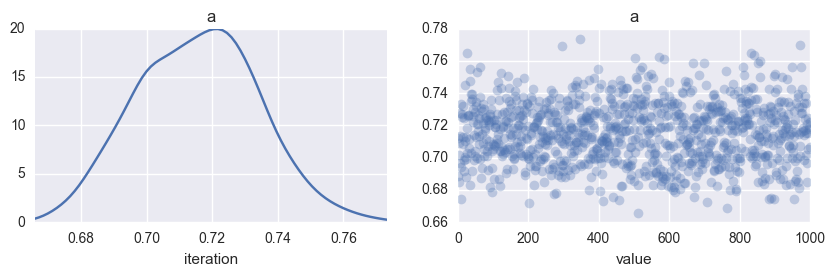

In [6]:
# plot estimates for alpha (intercept)
tools.plot_fit_params(unpooled_fit, ['a'])

In [7]:
print(tools.print_intervals(unpooled_fit, 'a', 95))

a 95%CI: 0.682..0.752


Considering the reduced test data set, we now find we have quite a different intercept ($\bar{\alpha} \approx 79$), with a much broader range of estimates that span zero and sometimes take negative values.

Modifying the structure of the model has greatly modified our estimate of a "common intercept", and the wide range of values, combined with a potential for type S error, should suggest that we still need to refine it further.

In [8]:
# Get fits of beta by probe ID
unpooled_estimates = pd.Series(unpooled_fit['b'].mean(0), index=probe_ids)
unpooled_se = pd.Series(unpooled_fit['b'].std(0), index=probe_ids)

In [9]:
# Inspect the estimates
unpooled_estimates.head()

A_07_P038676    0.462177
A_07_P033759    0.500899
A_07_P033727    0.470300
A_07_P033715    0.470755
A_07_P040893    1.223294
dtype: float64

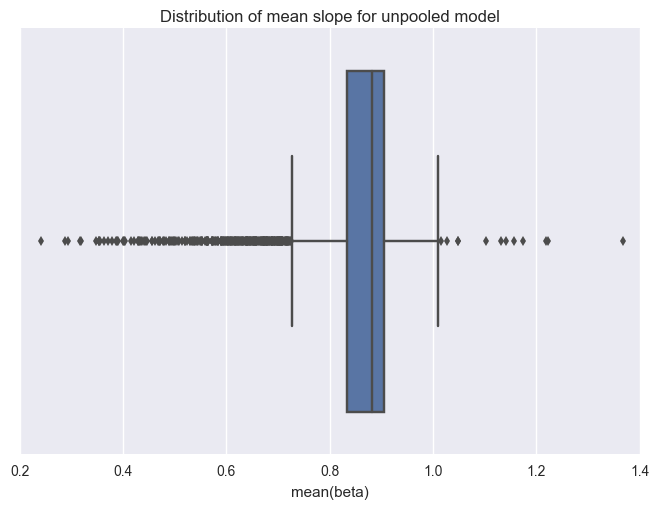

In [10]:
# Plot distribution
g = sns.boxplot(unpooled_estimates)
g.set_title("Distribution of mean slope for unpooled model")
g.set_xlabel("mean(beta)");

From the boxplot we can see that the distribution of mean inferred values of $\beta$ (by probe ID) is very tight, and they lie mostly close to zero. There are quite a few negative outlying values, and fewer positive outliers.

We are primarily interested in the outlying values of $\beta$, as these represent strong inferred effects on gene recovery after conducting the experiment (strong effects on *output* measurement, with respect to the *input* measurement). Negative values may be associated with genes that are deleterious in the experiment, positive values genes that are preferentially retained and provide an advantage in the experimental context.

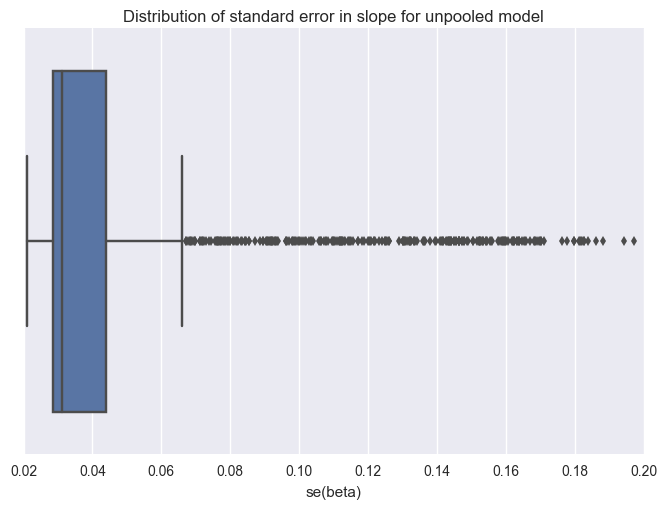

In [16]:
# plot standard errors
g = sns.boxplot(unpooled_se)
g.set_title("Distribution of standard error in slope for unpooled model")
g.set_xlabel("se(beta)");

The estimated values of $\beta$ are just estimates, but we can also get an idea of the certainty we have in the estimate by looking at the standard error of $\beta$. Where this is close to zero, we can be confident in our estimate of the parameter under this model. Where it is large - perhaps larger than the value of $\beta$ itself - we should treat the estimate with caution.

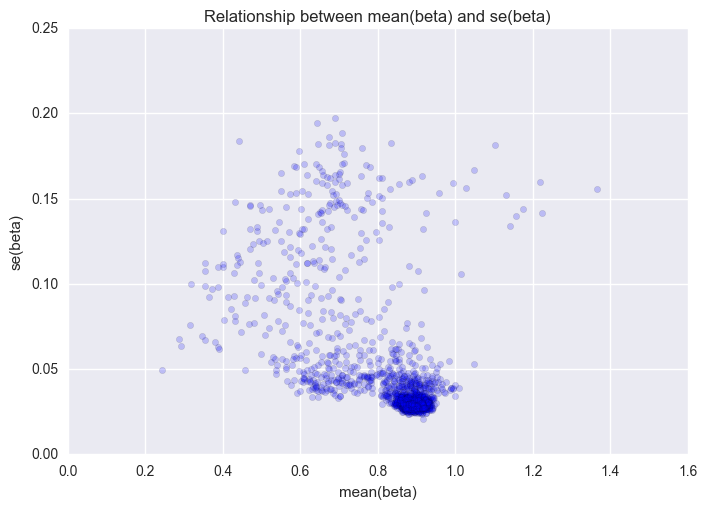

In [12]:
# How does estimate of error relate to error in the estimate
plt.scatter(unpooled_estimates, unpooled_se, alpha=0.2)
plt.title("Relationship between mean(beta) and se(beta)")
plt.xlabel("mean(beta)")
plt.ylabel("se(beta)");

From the above plot we can see that thre appears to be a relationship such that the more variable estimates of $\beta$ are also the larger estimates of $\beta$. This could occur for a number of reasons.

* the error in $\beta$ may just be proportional to $|\beta|$ - but the bulk of estimates appear to have $0 < \beta < 2$ with a standard error of close to zero, which would seem to contradict that
* the genes that are strongly advantageous or deleterious may only show that effect in the experiments where *treatment* is applied: the exact effect we want to see! 
* the pooled estimate of $\alpha$ is a negative effect on our ability to fit these larger $\beta$ values

This result is possibly an encouraging sign that we are closing in on the effect we want to identify, but we will need to modify the model structure to see this directly.

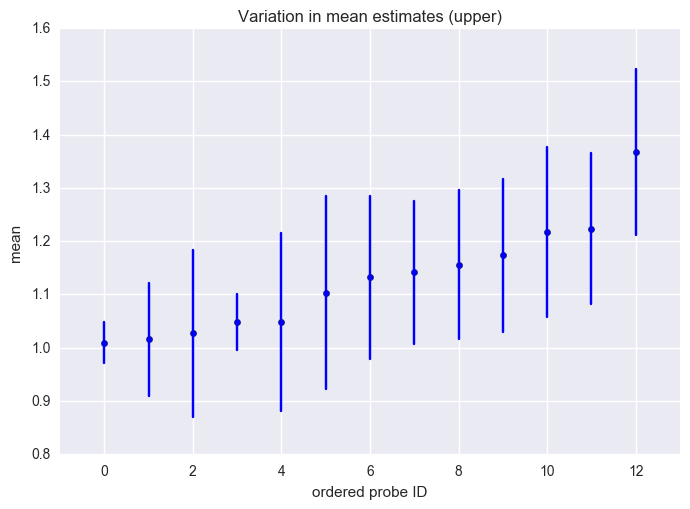

In [13]:
# plot error in estimate of beta for larger positive values
tools.plot_threshold_errors(unpooled_estimates, unpooled_se, 1, upper=True)

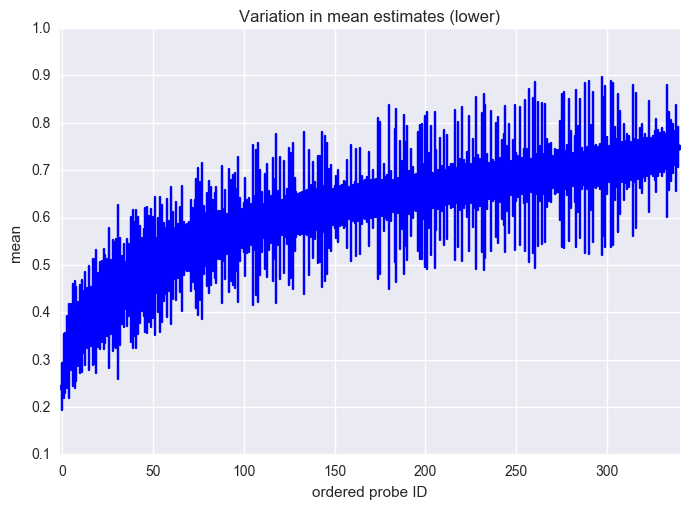

In [15]:
# plot error in estimate of beta for larger negative values
tools.plot_threshold_errors(unpooled_estimates, unpooled_se, 0.75, upper=False)

For both positive and negative large values, we can confirm that the largest values tend to have relatively large uncertainty in their estimates.

At this point, we are still not capturing information important for our central question:

* we are combining experiments with and without passage
* we are assuming a pooled intercept (the same base level of expression for all probes)
* whether probes that hybridise to Sakai have a different signal
* we are not incorporating any pertinent biological information (e.g. hierarchy of operons/regulons)

and it is possible that by extending our model we can reduce the variability we see in these estimates.